<a href="https://colab.research.google.com/github/beastboy-93/wildecho/blob/main/footprint.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Found 10 classes: ['Bear', 'Bobcat', 'Deer', 'Fox', 'Horse', 'Lion', 'Mouse', 'Racoon', 'Squirrel', 'Wolf']
Epoch 1/50


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 61ms/step - accuracy: 0.1650 - loss: 2.8265
Epoch 1: val_accuracy improved from -inf to 0.09091, saving model to /content/drive/MyDrive/best_footprint.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.1654 - loss: 2.8240 - val_accuracy: 0.0909 - val_loss: 4.2164 - learning_rate: 5.0000e-04
Epoch 2/50
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.2410 - loss: 2.4013
Epoch 2: val_accuracy improved from 0.09091 to 0.11818, saving model to /content/drive/MyDrive/best_footprint.keras
83/83 ━━━━━━━━━━━━━━━━━━━━ 3s 41ms/step - accuracy: 0.2410 - loss: 2.4010 - val_accuracy: 0.1182 - val_loss: 3.1171 - learning_rate: 5.0000e-04
Epoch 3/50
82/83 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step - accuracy: 0.2378 - loss: 2.3534
Epoch 3: val_accuracy did not improve from 0.11818
83/83 ━━━━━━━━━━━━━━━━━━━━ 4s 28ms/step - accuracy: 0.2379 - loss: 2.3539 - val_accuracy: 0.1000 - val_loss: 2.8996 - learning_rate: 5.0000e-04
Epoch 4/50
83/83 ━━━━━━━━━━━━━━━━━━━━ 0s 26

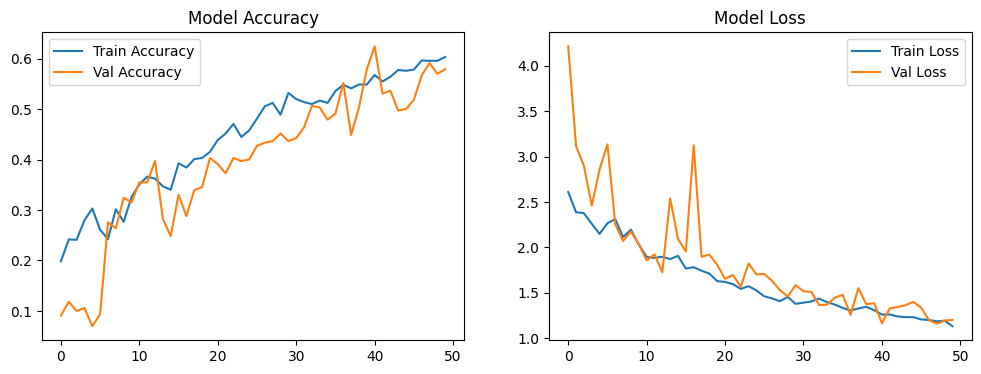

Test set accuracy: 0.6242
11/11 ━━━━━━━━━━━━━━━━━━━━ 1s 44ms/step

Classification Report:
              precision    recall  f1-score   support

        Bear       0.45      0.70      0.55        33
      Bobcat       0.56      0.45      0.50        33
        Deer       0.55      0.55      0.55        33
         Fox       0.69      0.33      0.45        33
       Horse       0.89      1.00      0.94        33
        Lion       0.57      0.64      0.60        33
       Mouse       0.93      0.82      0.87        33
      Racoon       0.38      0.45      0.42        33
    Squirrel       0.74      0.88      0.81        33
        Wolf       0.64      0.42      0.51        33

    accuracy                           0.62       330
   macro avg       0.64      0.62      0.62       330
weighted avg       0.64      0.62      0.62       330

Detected footprint: Horse (Confidence: 0.34)


('Horse', np.float32(0.33719066))

In [27]:
# Mount Google Drive and import libraries
from google.colab import drive
import os
import cv2
import numpy as np
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization, Input
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt

# Mount Drive
drive.mount('/content/drive')

# Define paths and parameters
dataset_path = "/content/drive/MyDrive/footprints"
test_image_path = "/content/drive/MyDrive/test_fp/lion_1.jpg"
img_size = 128
num_classes = 10
model_path = "/content/drive/MyDrive/best_footprint.keras"

# Load and preprocess images
def load_images(dataset_path):
    X, y = [], []
    class_labels = sorted(os.listdir(dataset_path))
    print(f"Found {len(class_labels)} classes: {class_labels}")

    for label_index, class_name in enumerate(class_labels):
        class_path = os.path.join(dataset_path, class_name)
        if not os.path.isdir(class_path):
            continue
        for img_name in os.listdir(class_path):
            img_path = os.path.join(class_path, img_name)
            img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if img is None:
                continue
            img = cv2.resize(img, (img_size, img_size))
            img = img / 255.0
            X.append(img)
            y.append(label_index)

    X = np.array(X).reshape(-1, img_size, img_size, 1)
    y = to_categorical(np.array(y), num_classes)
    return X, y, class_labels

# Load dataset
X, y, class_labels = load_images(dataset_path)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Augmentation
datagen = ImageDataGenerator(
    rotation_range=30,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    vertical_flip=True,
    fill_mode='nearest'
)
datagen.fit(X_train)

# Model definition
model = Sequential([
    Input(shape=(img_size, img_size, 1)),
    Conv2D(32, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu', padding='same'),
    BatchNormalization(),
    MaxPooling2D((2, 2)),
    Flatten(),
    Dense(256, activation='relu'),
    BatchNormalization(),
    Dropout(0.5),
    Dense(128, activation='relu'),
    Dropout(0.3),
    Dense(num_classes, activation='softmax')
])

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0005),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Callbacks
callbacks = [
    ReduceLROnPlateau(monitor='val_accuracy', factor=0.5, patience=5, min_lr=1e-6, verbose=1),
    EarlyStopping(monitor='val_accuracy', patience=15, restore_best_weights=True, verbose=1),
    ModelCheckpoint(model_path, monitor='val_accuracy', save_best_only=True, verbose=1)
]

# Train model
history = model.fit(datagen.flow(X_train, y_train, batch_size=16),
                    validation_data=(X_test, y_test),
                    epochs=50,
                    callbacks=callbacks,
                    verbose=1)

# Plot training history
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.legend()
plt.show()

# Load best model
best_model = load_model(model_path)

# Evaluate final model on test set
test_loss, test_accuracy = best_model.evaluate(X_test, y_test, verbose=0)
print(f"Test set accuracy: {test_accuracy:.4f}")

# Classification report
y_pred_probs = best_model.predict(X_test)
y_pred = np.argmax(y_pred_probs, axis=1)
y_true = np.argmax(y_test, axis=1)
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_labels))

# Detect single image
def detect_footprint(img_path, model, class_labels):
    img = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
    if img is None:
        print(f"Failed to load image: {img_path}")
        return None
    img = cv2.resize(img, (img_size, img_size))
    img = img / 255.0
    img = np.array(img).reshape(1, img_size, img_size, 1)
    prediction = model.predict(img, verbose=0)
    predicted_class_idx = np.argmax(prediction)
    predicted_class = class_labels[predicted_class_idx]
    confidence = prediction[0][predicted_class_idx]
    print(f"Detected footprint: {predicted_class} (Confidence: {confidence:.2f})")
    return predicted_class, confidence

# Detect test image
detect_footprint(test_image_path, best_model, class_labels)
